## Purpose of module

This module uses the technique described in 'Online short-term solar forecasting' by Bacher P, Madsen H & Nielsen HA (2009) to normalise the mean direct horizontal radiation by dividing by a clear sky model, created by smoothing the data in two dimensions; day of the year and hour of the day. 

## Import modules, load and transform data

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import pytz
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
PV_2017 = pd.read_csv('..//solar_data/PV_2017.csv',parse_dates=['date_time'],index_col='date_time')

# The timestamp in the input data is set to UTC but Pandas strips the time zone information when parsing.
# The following operation first creates 'time zone aware' timestamps, then localises it to Adelaide time.
PV_2017.index = PV_2017.index.tz_localize('UTC').tz_convert('Australia/Adelaide')

In [3]:
use_cols = ['mean_dir_horiz'] # Assuming this is the same as Global Horizontal Irradiance (GHI)
PV_2017 = PV_2017[use_cols]

In [4]:
PV_2017.head()

,mean_dir_horiz
date_time,
2017-01-01 00:00:00+10:30,0.0
2017-01-01 00:01:00+10:30,0.0
2017-01-01 00:02:00+10:30,0.0
2017-01-01 00:03:00+10:30,0.0
2017-01-01 00:04:00+10:30,0.0


In [5]:
# Confirm that the index is a time zone aware datetime object - return first and last objects
[PV_2017.iloc[0].name,PV_2017.iloc[-1].name]

[Timestamp('2017-01-01 00:00:00+1030', tz='Australia/Adelaide'),
 Timestamp('2017-12-31 23:59:00+1030', tz='Australia/Adelaide')]

Create new variables;

 * Time of day
 * Day of year

In [6]:
# Add time of day (in minutes from midnight at the start of each day)
PV_2017['time_of_day'] = PV_2017.index.map(lambda x: (
    x.combine(x.date(),x.time()) - x.combine(x.date(),dt.time(0,0))).seconds / 60 + 1)

In [7]:
# Add day of year 
first_day_of_year = dt.date(2017,1,1)
PV_2017['day_of_year'] = PV_2017.index.map(lambda x: (x.date() - first_day_of_year).days + 1)

In [8]:
PV_2017.head()

,mean_dir_horiz,time_of_day,day_of_year
date_time,,,
2017-01-01 00:00:00+10:30,0.0,1.0,1
2017-01-01 00:01:00+10:30,0.0,2.0,1
2017-01-01 00:02:00+10:30,0.0,3.0,1
2017-01-01 00:03:00+10:30,0.0,4.0,1
2017-01-01 00:04:00+10:30,0.0,5.0,1


In [9]:
PV_2017.tail()

,mean_dir_horiz,time_of_day,day_of_year
date_time,,,
2017-12-31 23:55:00+10:30,0.0,1436.0,365
2017-12-31 23:56:00+10:30,0.0,1437.0,365
2017-12-31 23:57:00+10:30,0.0,1438.0,365
2017-12-31 23:58:00+10:30,0.0,1439.0,365
2017-12-31 23:59:00+10:30,0.0,1440.0,365


In [10]:
# There are some missing values in the data
PV_2017.mean_dir_horiz.isnull().values.any()

True

In [11]:
# Replace all missing values with zero
PV_2017 = PV_2017.fillna(0)

# Should this be the average of the nearest time_of_day and day_of_year points nearby? 

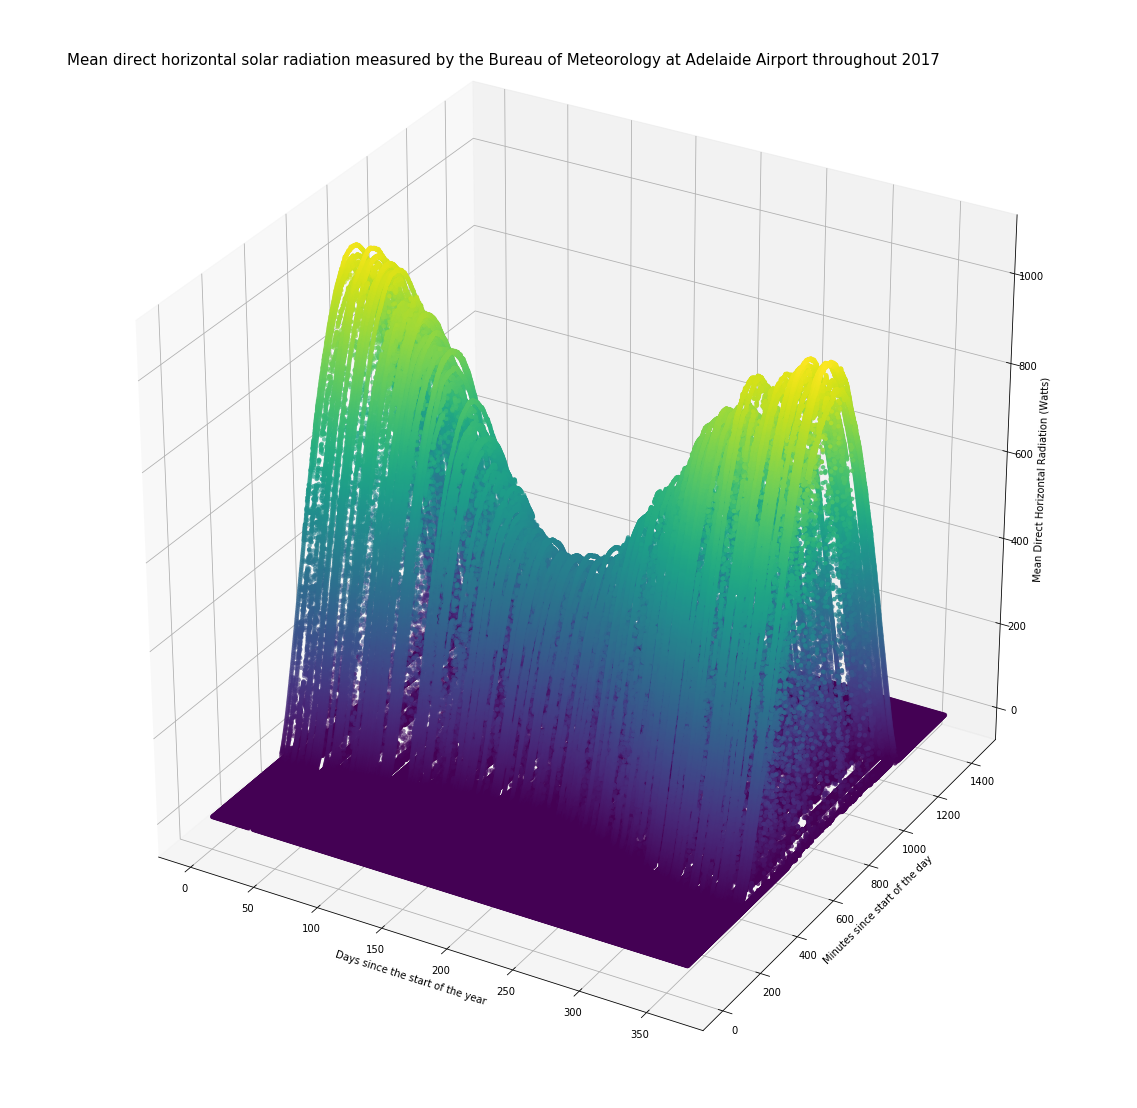

In [12]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_2017.day_of_year, PV_2017.time_of_day, PV_2017.mean_dir_horiz, 
                c=PV_2017.mean_dir_horiz, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since the start of the year')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Radiation (Watts)')
plt.show()

## Calculate 'clear sky' prediction of solar radiation at each minute of each day

Appendix A of Bache, Madsen & Nielsen (2009) describe a method for calculating estimated clear sky solar power $\hat{p}_{t}^{cs}$ given a solar power time series {$p_t$, $t=1$,...,$N$}, found as the $q$ quantile of ${ {f}_{P} }_{t}$, which is the probability distribution function of $P_t$.

The problem is reduced to estimating $\hat{p}_{t}^{cs}$ as a local constant for each $(x_t,y_t)$, where x is the day of the year and y is the time of day.  

The first step is to create a loss function $p(q,\epsilon_i$), where:

\begin{equation*}
p(q,\epsilon_i) =
\begin{cases}
    q\epsilon_i ,\quad \quad \quad \epsilon_i >= 0,  \\
    (1 - q)\epsilon_i ,\quad \epsilon_i < 0, \\
\end{cases}
\end{equation*}

and 

\begin{equation*}
\epsilon_i = p_i - \hat{p}_{t}^{cs}
\end{equation*}

In [13]:
# To be continued...